## Analysis of MD trajectories of RNA oligomers

- open `importdata.ipynb` notebook on my workstation (`2_tetramers` folder); for this aim, use jupyter notebook, since vs code is not working any more (either on the workstation or the cluster Ulysses); to use jupyter notebook, look at the instructions in my github `my_scripts/remote_access_jupyter` (reported in the following)
- visualize trajectories with `nglview` (at least first subtrajectory)
- compute distances between fixed atoms in each nucleobase (for example, among C5 carbon atoms in AAAA oligomer)
- cluster on that distances; how many structures do you get? are the results of your clustering compatible with the clustering on dihedral angles?

conclusion:
- stacking is the driving force in these RNA oligomers
- there are several conformational structures, depending on which nucleobases stack on which (the most common structure is all the 4 nucleobases stacked on each other 1-2-3-4, but also stacking with couples is possible)
- these oligomers are too small to have Watson-Crick pairings
- see also paper ***Conformational ensembles of RNA oligonucleotides from integrating
NMR and molecular simulations*** by Bottaro, Bussi et al.

remember you make a (slight) mistake on frames corresponding to transitions between different clustered configurations (they should not belong to any cluster, is it right?)

**instructions for the remote access with jupyter notebook:**

open jupyter notebook on your workstation (with SSH):

- open a terminal (local)

`ssh igilardo@renoir.phys.sissa.it`

`jupyter notebook --no-browser --port=9999`

in this way you will access to the remote workstation;
then, open a second terminal

`ssh -NfL localhost:9999:localhost:9999 igilardo@renoir.phys.sissa.it`

now, open your browser to

`http://127.0.0.1:9999/tree`

the jupyter notebook of interest in our case is `2_tetramers/importdata.ipynb`

In [1]:
import os, pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
import sys, jax.numpy as jnp
sys.path.append('../../')

from MDRefine.MDRefine import load_data  # , normalize_observables, minimizer, unwrap_2dict, loss_function
# from Functions.basic_functions_bayesian import local_density

### 1. load data

In [15]:
infos = {'global': {
    # 'path_directory': 'MDRefine/MDRefine/tests/DATA_test',
    # DATA_test corresponds to stride = 1e4 and only one observable per type
    
    'path_directory': '../DATA/',
    
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs' , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    'obs': ['NOEs', 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 1

In [16]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [17]:
infos['global']['forward_model'] = forward_model_fun

In [18]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [19]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


### 2. analyse `forward_qs` (dihedral angles)

In [157]:
stride = 100
qs = data.mol['AAAA'].forward_qs['backbone1_gamma'][::stride]

qs.shape

(10170, 8)

(-3.141592653589793, 3.141592653589793)

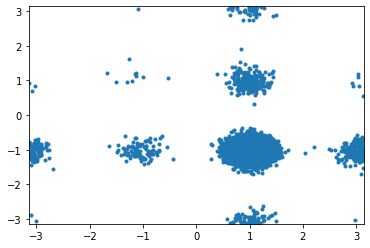

In [158]:
plt.plot(qs[:, 3], qs[:, 4], '.')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

it is not a good choice to do clustering on angles, due to periodicity $\pm \pi$, so let's take sin and cos

then, sort columns such the new cols 0 and 1 corresponds sin/cos of the same angle, and so on 

In [127]:
vals = np.hstack((np.cos(qs), np.sin(qs)))

l = qs.shape[1]
my_list = [[i, l + i] for i in range(l)]
my_list = [i2 for i in my_list for i2 in i]
print(my_list)

vals = vals[:, my_list]

[0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15]


[0 0 0 ... 0 0 0] 0.6367538


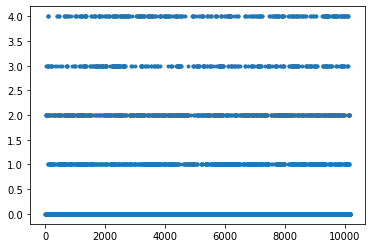

In [128]:
n_clusters = 5
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(vals)
score = silhouette_score(vals, labels)

print(labels, score)

plt.plot(labels, '.')

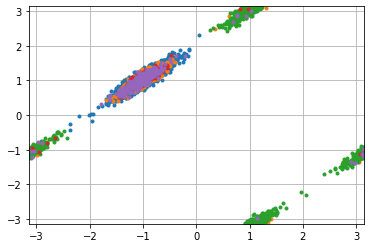

In [148]:
for i in range(n_clusters):
    wh = np.argwhere(labels == i)
    plt.plot(qs[:, 0][wh], qs[:, 1][wh], '.')

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.grid()

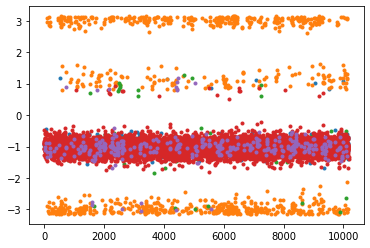

In [61]:
for i in range(n_clusters):
    wh = np.argwhere(labels == i)
    plt.plot(wh, qs[:, 6][wh], '.')

- focus on each cluster

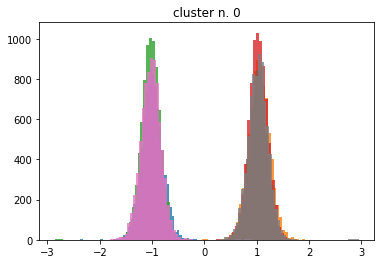

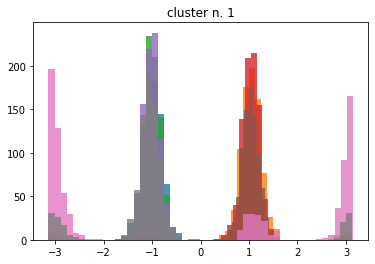

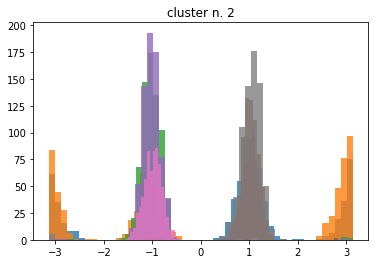

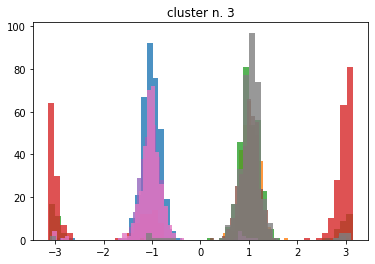

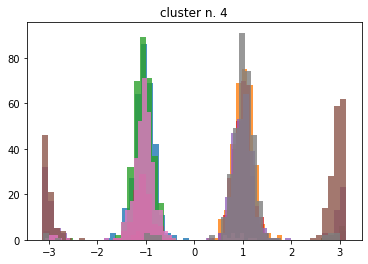

In [134]:
for i_cluster in range(n_clusters):
    plt.figure()
    plt.title('cluster n. %i' % i_cluster)
    
    wh = np.argwhere(labels == i_cluster)

    for i in range(qs.shape[1]):
        plt.hist(np.concatenate(qs[wh, i]), bins=50, alpha=0.8)

#### extrapolate to different observables

(10170, 9)


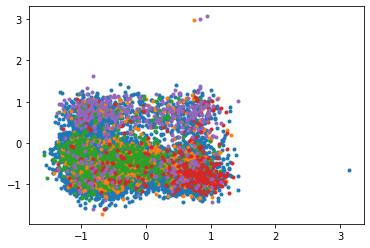

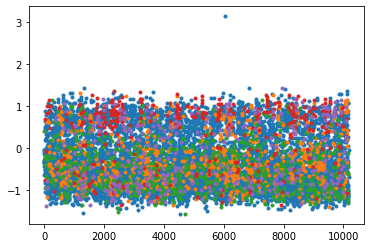

In [175]:
new_qs = data.mol['AAAA'].forward_qs['backbone2_beta_epsilon'][::stride]

print(new_qs.shape)

for i_cluster in range(n_clusters):
    wh = np.argwhere(labels == i_cluster)
    plt.plot(new_qs[wh, 0], new_qs[wh, 3], '.')

plt.figure()
for i_cluster in range(n_clusters):
    wh = np.argwhere(labels == i_cluster)
    plt.plot(wh, new_qs[wh, 0], '.')

#### 1st question: few dihedral angles
if I cluster only on the first n angles, do I get results compatible with clustering over all the dihedral angles in `forward_qs`?

- keep the same `n_clusters = 5`

In [115]:
km = KMeans(n_clusters=5)

labels_list = []
score_list = []

for i in range(1, qs.shape[1] + 1):
    print('n. angles: ', i)
    labels_list.append(km.fit_predict(vals[:, :2*i]))
    score_list.append(silhouette_score(vals[:, :2*i], labels_list[-1]))


n. angles:  1
n. angles:  2
n. angles:  3
n. angles:  4
n. angles:  5
n. angles:  6
n. angles:  7
n. angles:  8


score list, 2 clusters

[0.8336696,
 0.8287808,
 0.75929695,
 0.7230578,
 0.6764616,
 0.6501549,
 0.5788846,
 0.5638173]

score list, 5 clusters

[0.5473917,
 0.46993312,
 0.38838285,
 0.33315068,
 0.67917293,
 0.7191754,
 0.5820661,
 0.6367538]

score list, 8 clusters

 [0.5230222,
 0.40517694,
 0.35218537,
 0.33036307,
 0.28405845,
 0.2785803,
 0.2505651,
 0.24108663]

score list, 10 clusters

[0.51665735,
 0.3690321,
 0.32744792,
 0.3121795,
 0.27988157,
 0.26618728,
 0.27303275,
 0.24165085]

so the optimal is about 5 clusters

In [123]:
how_many = {}
wh = {}

for i_cluster in range(n_clusters):
    how_many[i_cluster] = {}
    wh[i_cluster] = {}
    for n_angle, labels in enumerate(labels_list):
        wh[i_cluster][n_angle] = np.argwhere(labels == i_cluster)
        how_many[i_cluster][n_angle] = len(wh[i_cluster][n_angle])

how_many

{0: {0: 2472, 1: 4448, 2: 4616, 3: 4525, 4: 316, 5: 8679, 6: 8190, 7: 350},
 1: {0: 2409, 1: 472, 2: 472, 3: 471, 4: 471, 5: 469, 6: 818, 7: 342},
 2: {0: 471, 1: 316, 2: 316, 3: 383, 4: 378, 5: 370, 6: 470, 7: 700},
 3: {0: 317, 1: 2660, 2: 4389, 3: 314, 4: 8679, 5: 314, 6: 377, 7: 863},
 4: {0: 4501, 1: 2274, 2: 377, 3: 4477, 4: 326, 5: 338, 6: 315, 7: 7915}}

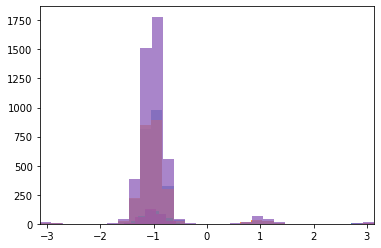

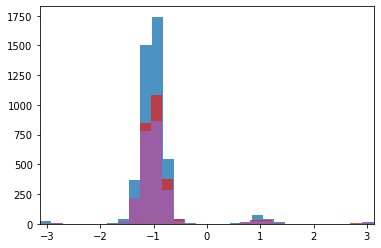

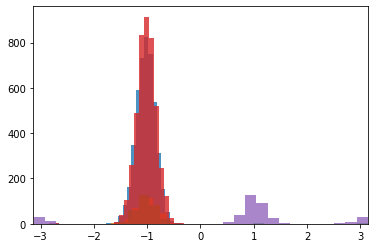

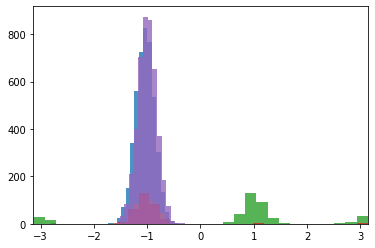

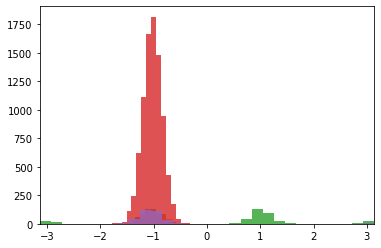

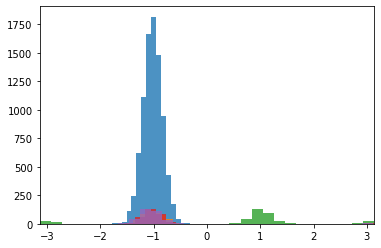

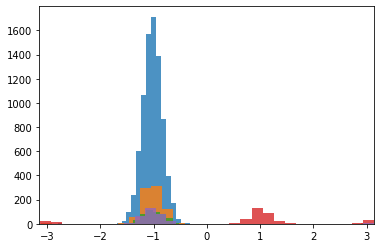

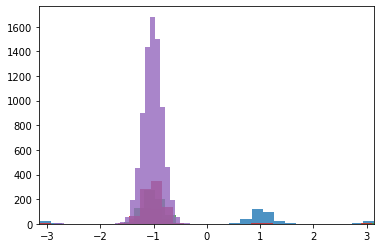

In [125]:
for j in range(8):
    plt.figure()

    for i in range(5):
        plt.hist(np.concatenate(qs[:, 2][wh[i][j]]), alpha=0.8, bins=30)  # , density=True)

    plt.xlim([-np.pi, np.pi])

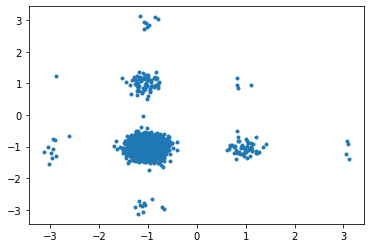

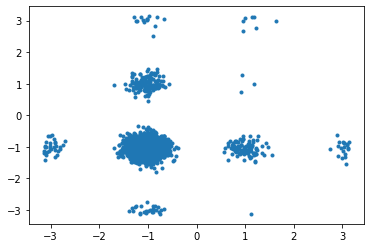

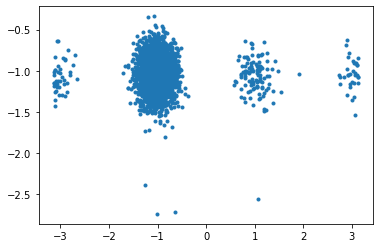

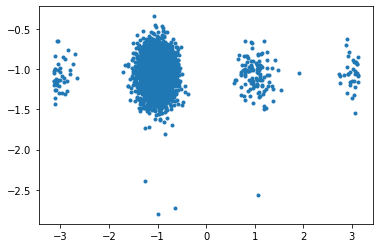

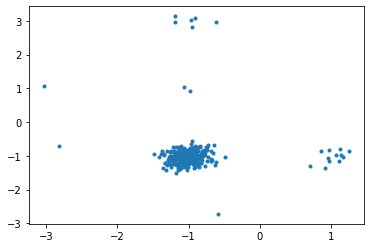

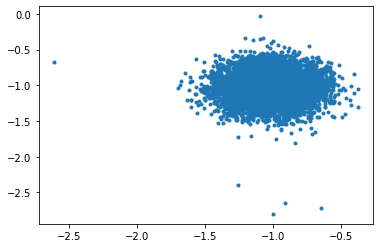

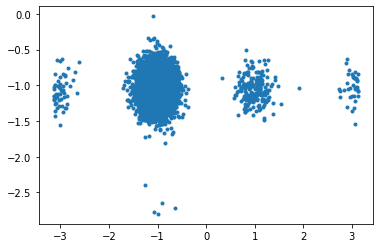

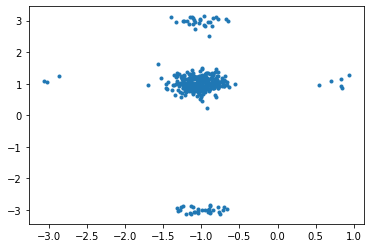

In [118]:
i_cluster = 0

for labels in labels_list:
    wh = np.argwhere(labels == i_cluster)
    plt.figure()
    plt.plot(qs[:, 4][wh], qs[:, 2][wh], '.')

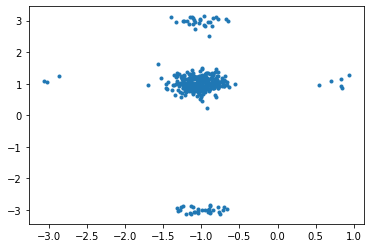

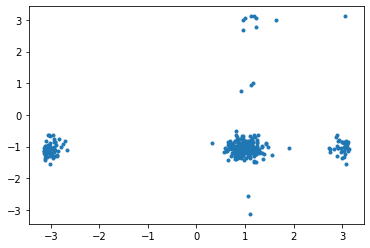

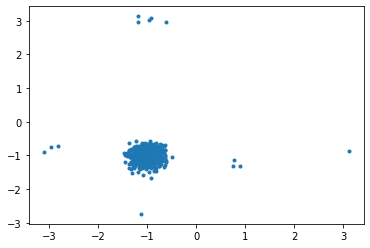

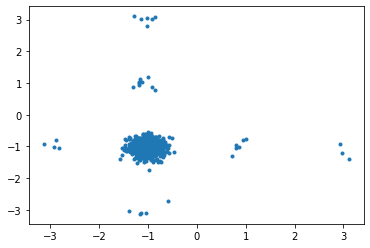

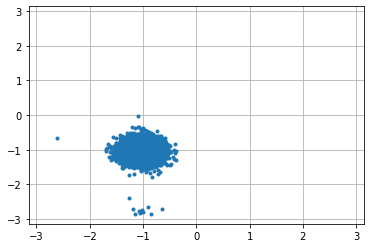

In [126]:
for i in range(n_clusters):
    plt.figure()
    wh = np.argwhere(labels == i)
    plt.plot(qs[:, 4][wh], qs[:, 2][wh], '.')

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.grid()

### 3. analyse distances between nucleobases

In [4]:
names = ['1-2', '1-3', '1-4', '2-3', '2-4', '3-4']

In [ ]:
distances = np.load('../distances.npy')
distances = distances[:, [1, 2, 3, 5, 6, 8]]  # remove distances between an atom and itself (computed by mistake)

distances.shape

(85001, 6)

(array([2.9800e+02, 3.9640e+03, 1.1673e+04, 1.2313e+04, 8.2420e+03,
        5.4570e+03, 4.1310e+03, 3.2550e+03, 2.6110e+03, 2.2310e+03,
        2.0080e+03, 1.9270e+03, 1.8750e+03, 1.8550e+03, 2.9570e+03,
        3.3740e+03, 2.0830e+03, 1.0260e+03, 7.0600e+02, 5.4700e+02,
        5.5600e+02, 5.2200e+02, 5.0900e+02, 4.9600e+02, 4.3800e+02,
        4.2700e+02, 3.9500e+02, 3.7900e+02, 4.1200e+02, 4.1600e+02,
        5.2700e+02, 5.5200e+02, 6.7500e+02, 6.1600e+02, 5.1100e+02,
        4.4800e+02, 4.0100e+02, 4.0700e+02, 4.1000e+02, 5.0000e+02,
        5.3400e+02, 6.1900e+02, 5.8400e+02, 4.4700e+02, 3.1300e+02,
        2.0900e+02, 9.7000e+01, 4.6000e+01, 1.6000e+01, 6.0000e+00]),
 array([ 3.0546546,  3.3121476,  3.5696409,  3.827134 ,  4.084627 ,
         4.34212  ,  4.599613 ,  4.857106 ,  5.114599 ,  5.3720922,
         5.6295853,  5.887079 ,  6.144572 ,  6.402065 ,  6.659558 ,
         6.917051 ,  7.174544 ,  7.432037 ,  7.6895304,  7.9470234,
         8.204516 ,  8.462009 ,  8.719502 ,  8

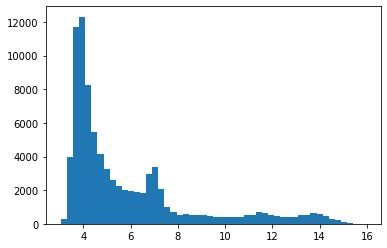

In [6]:
plt.hist(distances[:, 0], bins=50)

#### which is the optimal n. of clusters?

In [7]:
score_list = []

for n_clusters in range(2, 20):
    print('n. clusters: ', n_clusters)
    stride = 5

    km = KMeans(n_clusters=n_clusters)
    labels = km.fit_predict(distances[::stride])
    score_list.append(silhouette_score(distances[::stride], labels))

print(score_list)

n. clusters:  2
n. clusters:  3
n. clusters:  4
n. clusters:  5
n. clusters:  6
n. clusters:  7
n. clusters:  8
n. clusters:  9
n. clusters:  10
n. clusters:  11
n. clusters:  12
n. clusters:  13
n. clusters:  14
n. clusters:  15
n. clusters:  16
n. clusters:  17
n. clusters:  18
n. clusters:  19
[0.519594, 0.4201262, 0.44119623, 0.4544068, 0.46129128, 0.47652778, 0.43889558, 0.44834334, 0.40236044, 0.40707788, 0.40438327, 0.39825782, 0.39764708, 0.39683673, 0.39902127, 0.3525088, 0.32872716, 0.3308399]


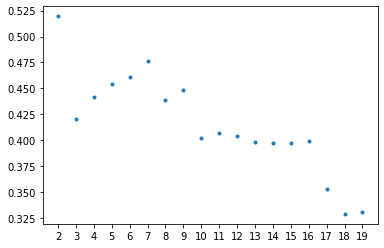

In [8]:
plt.plot(np.arange(2, 20), score_list, '.')
plt.xticks(np.arange(2, 20))
# plt.grid()
plt.show()

so let's take 9 clusters

#### cluster

[0 0 0 ... 5 0 5] 0.4522161


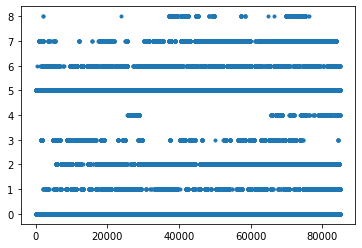

In [9]:
n_clusters = 9
stride = 1

km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(distances[::stride])
score = silhouette_score(distances[::stride], labels)

print(labels, score)

plt.plot(labels, '.')

<BarContainer object of 9 artists>

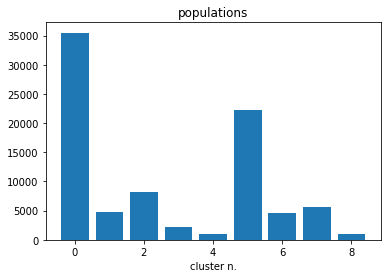

In [27]:
whs = []
pops = []

for i in range(n_clusters):
    whs.append(np.concatenate(np.argwhere(labels == i)))
    pops.append(len(whs[-1]))

plt.title('populations')
plt.xlabel('cluster n.')
plt.bar(np.arange(len(pops)), pops)

#### visualize the results
- `labels` is the array of cluster labels and `score` is its associated Silhouette score
- `whs` are the frame indices of each cluster
- `pops` is the population of each cluster

so you can plot both at fixed couple of atoms (and different clusters) or at fixed clusters

notice in the first case `density = True` or `False` will change the plot (namely, ratio between peaks) due to different populations of each cluster, while in the second case it will only affect the y-axis

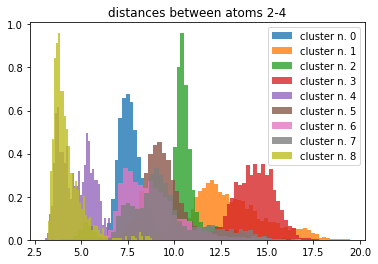

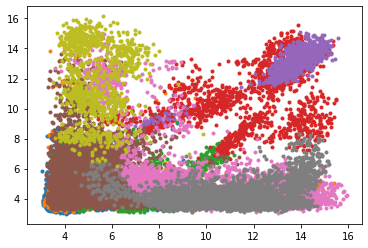

In [28]:
j = 4

for i in range(n_clusters):
    plt.hist(distances[::stride][whs[i], j], bins=50, alpha=0.8, label='cluster n. %i' % i, density=True)
    plt.title('distances between atoms %s' % names[j])
    plt.legend()

plt.figure()
for i in range(n_clusters):
    plt.plot(distances[::stride][whs[i], 0], distances[::stride][whs[i], 3], '.')

ok, now let's focus on a single cluster to see what it is

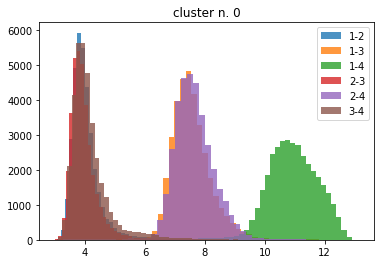

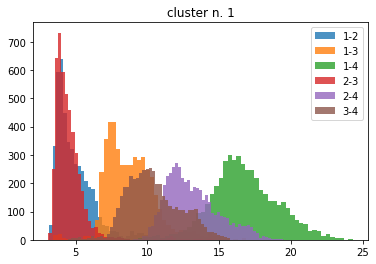

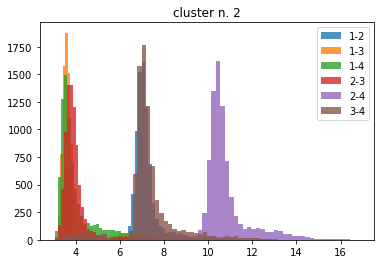

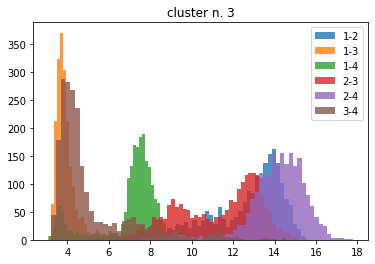

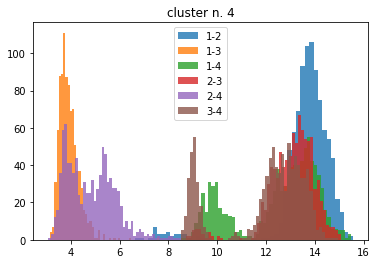

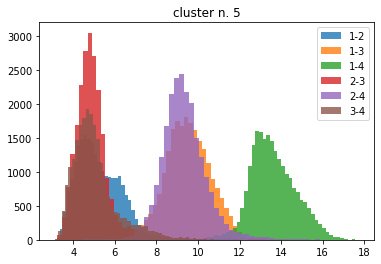

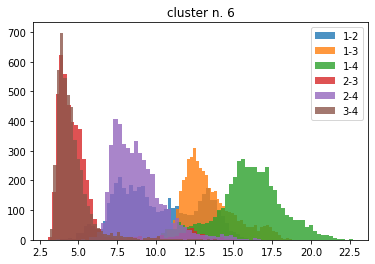

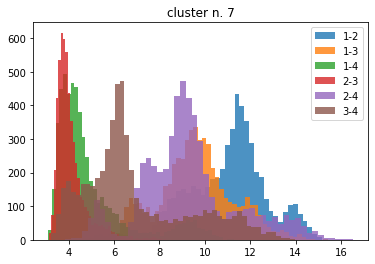

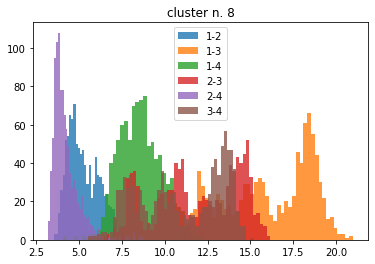

In [43]:
for i_cluster in range(n_clusters):
    plt.figure()
    
    for i in range(distances.shape[1]):
        plt.hist(distances[::stride][whs[i_cluster], i], bins=50, alpha=0.8, label=names[i])

    plt.title('cluster n. %i' % i_cluster)
    plt.legend()

clusters n. 0 and 5 could belong to the same "configurational structure"...

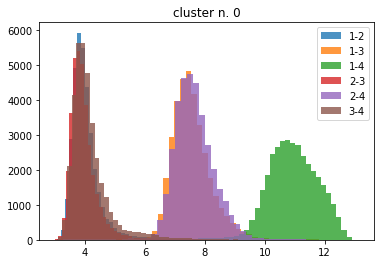

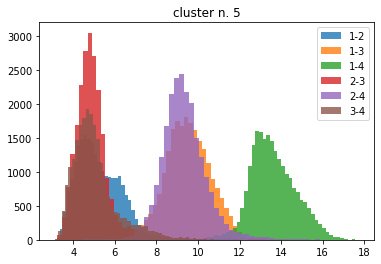

In [42]:
for i_cluster in [0, 5]:  # range(n_clusters):
    plt.figure()
    
    for i in range(distances.shape[1]):
        plt.hist(distances[::stride][whs[i_cluster], i], bins=50, alpha=0.8, label=names[i])

    plt.title('cluster n. %i' % i_cluster)
    plt.legend()

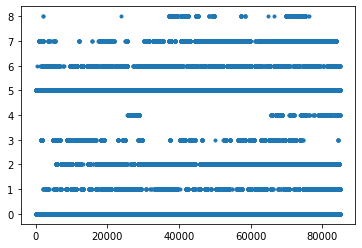

In [39]:
plt.plot(labels, '.')

In [41]:
[whs[i][:3] for i in range(len(whs))]

[array([0, 1, 2]),
 array([1992, 1995, 1996]),
 array([5743, 5744, 5748]),
 array([1461, 1462, 1469]),
 array([25552, 25683, 25684]),
 array([89, 90, 91]),
 array([ 234, 1308, 1357]),
 array([763, 764, 817]),
 array([ 2146,  2147, 23913])]

does this correspond to the previous clustering, on the dihedral angles?

### plot the observables

In [24]:
g = data.mol['AAAA'].g[s]#.keys()#[s]
g_mean = np.mean(g, axis=0)

g_mean.shape

(244,)

In [44]:
np.sum(data.mol['AAAA'].names[s], axis=1)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U7'), dtype('<U7')) -> None

In [43]:
np.stack(data.mol['AAAA'].names[s], axis=0).shape

(36, 2)

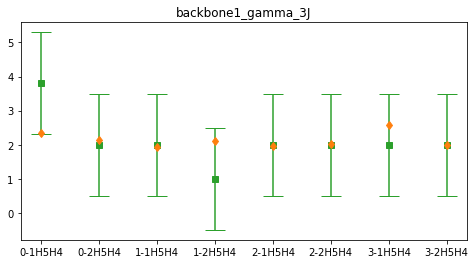

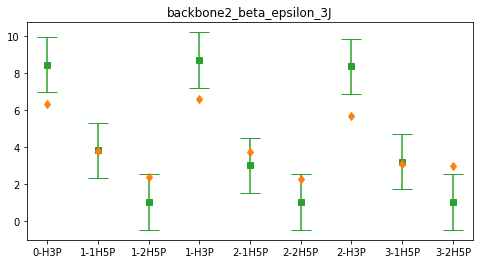

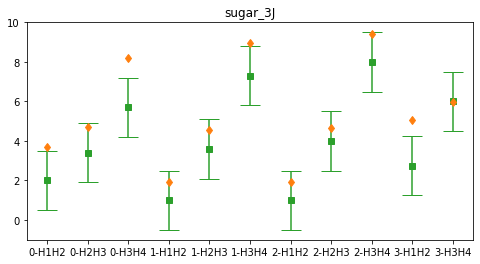

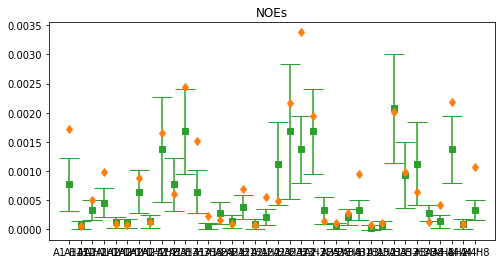

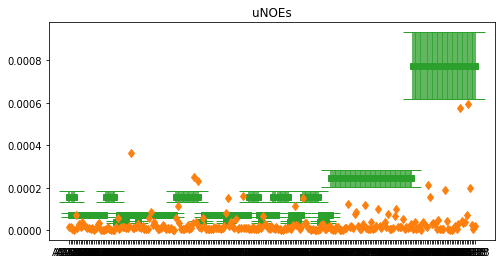

In [48]:
for s in data.mol['AAAA'].gexp.keys():
    
    g_exp = data.mol['AAAA'].gexp[s]

    g = data.mol['AAAA'].g[s]
    g_mean = np.mean(g, axis=0)
    
    plt.figure(figsize=(8, 4))
    plt.title(s)
    
    plt.plot(g_exp[:, 0], 's', c='tab:green')
    plt.errorbar(np.arange(g_exp.shape[0]), g_exp[:, 0], yerr=g_exp[:, 1], linestyle='', capsize=10., c='tab:green')

    plt.plot(g_mean, 'd', c='tab:orange')

    plt.xticks(np.arange(len(g_mean)), labels=data.mol['AAAA'].names[s][:, 0])